In [7]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
import tqdm

from torch.optim import SGD, Adam
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [3]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.user_embedding_mf = nn.Embedding(nb_users, mf_dim)
        self.item_embedding_mf = nn.Embedding(nb_items, mf_dim)

        self.user_embedding_mlp = nn.Embedding(nb_users, mlp_layer_sizes[0] // 2)
        self.item_embedding_mlp = nn.Embedding(nb_items, mlp_layer_sizes[0] // 2)
        
        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        mlp_layers = []
        input_size = mlp_layer_sizes[0]
        for layer_size in mlp_layer_sizes[1:]:
            mlp_layers.append(nn.Linear(input_size, layer_size))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(dropout))
            input_size = layer_size
        self.mlp = nn.Sequential(*mlp_layers)
        self.final = nn.Linear(mf_dim + mlp_layer_sizes[-1], 1)
        
        #YOUR TASK: Initialze weights ~4 lines of code - use glorot (final MLP has to use lecunn
        self._init_weights()
        
    def _init_weights(self):
        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)
            
        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)
            
        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.final)

    def forward(self, user, item, sigmoid=False):
        user_embedding_mf = self.user_embedding_mf(user)
        item_embedding_mf = self.item_embedding_mf(item)
        user_embedding_mlp = self.user_embedding_mlp(user)
        item_embedding_mlp = self.item_embedding_mlp(item)
        
        mf_output = user_embedding_mf * item_embedding_mf
        
        mlp_input = torch.cat((user_embedding_mlp, item_embedding_mlp), dim=-1)
        mlp_output = self.mlp(mlp_input)
        
        concat_output = torch.cat((mf_output, mlp_output), dim=-1)
        
        output = self.final(concat_output)
        if sigmoid:
            output = torch.sigmoid(output)
        
        return output

In [4]:
if __name__ == "__main__":
    nb_users = 1000
    nb_items = 1700
    mf_dim = 10
    mlp_layer_sizes = [64, 32, 16, 8]

    model = NeuMF(nb_users, nb_items, mf_dim, mlp_layer_sizes)
    user_id = torch.tensor([1])
    item_id = torch.tensor([10])
    output = model(user_id, item_id, sigmoid=True)
    print(output)

tensor([[0.4542]], grad_fn=<SigmoidBackward0>)


### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [5]:
class ML100kDataset(Dataset):
    def __init__(self,file_name,negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'],axis=1,inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this! store them in self.users,self.items,self.labels
        all_items = set(range(1, max_item + 1))
        user_item_set = set(zip(ratings_df['user_id'], ratings_df['item_id']))
        users, items, labels = [], [], []
        #Sample neg users
        for (user, item) in user_item_set:
            users.append(user)
            items.append(item)
            labels.append(1)
        #sample neg items
            for _ in range(self.negative_samples):
                negative_item = np.random.choice(list(all_items - set(ratings_df[ratings_df['user_id'] == user]['item_id'])))
                users.append(user)
                items.append(negative_item)
                labels.append(0)
        #labels
        self.users = torch.tensor(users, dtype=torch.long)
        self.items = torch.tensor(items, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self,idx):
        return self.users[idx],self.items[idx],self.labels[idx]

In [6]:
if __name__ == "__main__":
    dataset = ML100kDataset('ml-100k/u.data', negative_samples=1)
    print(len(dataset))
    print(dataset[0])

200000
(tensor(244), tensor(509), tensor(1.))


### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [9]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code

opts = [Adam, SGD]
train_set = ML100kDataset('ml-100k/u1.base')
test_set = ML100kDataset('ml-100k/u1.test')
nb_users = 1000
nb_items = 1700
mf_dim = 16
mlp_layer_sizes = [128, 64, 32, 16]


kf = KFold(n_splits = 5, shuffle = True)

opt_test_loss = {}

for opt in opts:
    train_loss = []
    test_loss = []
    for fold, (train_index, test_index) in enumerate(kf.split(train_set)):
        print(f'Processing fold {fold} out of 5.')
        
        train_fold = torch.utils.data.Subset(train_set, train_index)
        test_fold = torch.utils.data.Subset(train_set, test_index)
        
        train_dl = DataLoader(train_fold, batch_size = 32, shuffle = True)
        test_dl = DataLoader(test_fold, batch_size = 32, shuffle = False)
        
        model = NeuMF(nb_users, nb_items, mf_dim, mlp_layer_sizes)
        loss_criterion = nn.BCELoss()
        optimizer = opt(model.parameters(), lr=0.001)
        
        fold_train_loss = []
        fold_test_loss = []
        
        for epoch in range(30):
            model.train()
            train_loss_on_epoch = []
            print(f'Epoch {epoch}/30.')
            
            for (u,i,l) in tqdm.tqdm(train_dl):
                optimizer.zero_grad()
                yhat = model(u, i, sigmoid = True)
                l = l.unsqueeze(1)
                loss = loss_criterion(yhat, l)
                train_loss_on_epoch.append(loss.item())
                loss.backward()
                optimizer.step()
            fold_train_loss.append(np.mean(train_loss_on_epoch))
            
            model.eval()
            predictions = []
            with torch.no_grad():
                test_loss_on_epoch = []
                for i, (u,i,l) in enumerate(test_dl):
                    yhat = model(u, i, sigmoid = True)
                    predictions.append(yhat)
                    l = l.unsqueeze(1)
                    t_loss = loss_criterion(yhat, l)
                    test_loss_on_epoch.append(t_loss.item())
                fold_test_loss.append(np.mean(test_loss_on_epoch))
                
        
        train_loss.append(fold_train_loss)
        test_loss.append(fold_test_loss)
        
    train_loss = np.array(train_loss)
    test_loss = np.array(test_loss)
    
    
    last_test_loss = test_loss[:, -1]
    last_train_loss = train_loss[:, -1]


    mean_train_loss = np.mean(last_train_loss, axis=0)
    mean_test_loss = np.mean(last_test_loss, axis=0)
    std_train_loss = np.std(last_train_loss, axis=0)
    std_test_loss = np.std(last_test_loss, axis=0)
    
    opt_test_loss[str(opt)] = mean_test_loss

    print("Mean Train Loss:", mean_train_loss)
    print("Mean Test Loss:", mean_test_loss)
    print("Std Train Loss:", std_train_loss)
    print("Std Test Loss:", std_test_loss)       

Processing fold 0 out of 5.
Epoch 0/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 513.14it/s]


Epoch 1/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 531.04it/s]


Epoch 2/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 535.72it/s]


Epoch 3/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 530.90it/s]


Epoch 4/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 535.22it/s]


Epoch 5/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 532.15it/s]


Epoch 6/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 535.93it/s]


Epoch 7/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 524.72it/s]


Epoch 8/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 518.82it/s]


Epoch 9/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 529.21it/s]


Epoch 10/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 536.72it/s]


Epoch 11/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 530.36it/s]


Epoch 12/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 524.88it/s]


Epoch 13/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 507.64it/s]


Epoch 14/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 513.79it/s]


Epoch 15/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 517.95it/s]


Epoch 16/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 526.76it/s]


Epoch 17/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 529.04it/s]


Epoch 18/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 524.44it/s]


Epoch 19/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 526.62it/s]


Epoch 20/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 540.03it/s]


Epoch 21/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 528.65it/s]


Epoch 22/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 533.16it/s]


Epoch 23/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 539.79it/s]


Epoch 24/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 533.02it/s]


Epoch 25/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 536.45it/s]


Epoch 26/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 535.72it/s]


Epoch 27/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 531.68it/s]


Epoch 28/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 528.29it/s]


Epoch 29/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 522.59it/s]


Processing fold 1 out of 5.
Epoch 0/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 524.84it/s]


Epoch 1/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 527.42it/s]


Epoch 2/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 531.11it/s]


Epoch 3/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 518.87it/s]


Epoch 4/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 508.55it/s]


Epoch 5/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 526.87it/s]


Epoch 6/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 525.47it/s]


Epoch 7/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 516.99it/s]


Epoch 8/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 518.39it/s]


Epoch 9/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 508.82it/s]


Epoch 10/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 498.11it/s]


Epoch 11/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 502.44it/s]


Epoch 12/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 528.96it/s]


Epoch 13/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 531.56it/s]


Epoch 14/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 524.08it/s]


Epoch 15/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 515.66it/s]


Epoch 16/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 509.71it/s]


Epoch 17/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 526.85it/s]


Epoch 18/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 526.89it/s]


Epoch 19/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 527.80it/s]


Epoch 20/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 525.58it/s]


Epoch 21/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 534.59it/s]


Epoch 22/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 525.40it/s]


Epoch 23/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 532.52it/s]


Epoch 24/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 524.47it/s]


Epoch 25/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 529.17it/s]


Epoch 26/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 526.26it/s]


Epoch 27/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 518.65it/s]


Epoch 28/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 524.19it/s]


Epoch 29/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 500.81it/s]


Processing fold 2 out of 5.
Epoch 0/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 504.02it/s]


Epoch 1/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 511.09it/s]


Epoch 2/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 526.42it/s]


Epoch 3/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 501.63it/s]


Epoch 4/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 512.47it/s]


Epoch 5/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 533.68it/s]


Epoch 6/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 498.71it/s]


Epoch 7/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 508.24it/s]


Epoch 8/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 512.68it/s]


Epoch 9/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 509.06it/s]


Epoch 10/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 534.73it/s]


Epoch 11/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 533.01it/s]


Epoch 12/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 539.09it/s]


Epoch 13/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 531.76it/s]


Epoch 14/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 520.12it/s]


Epoch 15/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 534.69it/s]


Epoch 16/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 538.01it/s]


Epoch 17/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 520.57it/s]


Epoch 18/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 529.50it/s]


Epoch 19/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 534.53it/s]


Epoch 20/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 528.10it/s]


Epoch 21/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 524.93it/s]


Epoch 22/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 517.25it/s]


Epoch 23/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 527.81it/s]


Epoch 24/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 502.08it/s]


Epoch 25/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 527.42it/s]


Epoch 26/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 526.92it/s]


Epoch 27/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 522.83it/s]


Epoch 28/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 527.89it/s]


Epoch 29/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 526.98it/s]


Processing fold 3 out of 5.
Epoch 0/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 529.71it/s]


Epoch 1/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 521.16it/s]


Epoch 2/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 476.39it/s]


Epoch 3/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 503.36it/s]


Epoch 4/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 499.41it/s]


Epoch 5/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 491.74it/s]


Epoch 6/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 487.56it/s]


Epoch 7/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 505.24it/s]


Epoch 8/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 504.61it/s]


Epoch 9/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 502.64it/s]


Epoch 10/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 507.03it/s]


Epoch 11/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 503.72it/s]


Epoch 12/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 504.99it/s]


Epoch 13/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 505.76it/s]


Epoch 14/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 508.15it/s]


Epoch 15/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 509.99it/s]


Epoch 16/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 499.81it/s]


Epoch 17/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 496.22it/s]


Epoch 18/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 501.85it/s]


Epoch 19/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 496.46it/s]


Epoch 20/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 506.89it/s]


Epoch 21/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 507.88it/s]


Epoch 22/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 513.42it/s]


Epoch 23/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 501.97it/s]


Epoch 24/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 508.89it/s]


Epoch 25/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 505.84it/s]


Epoch 26/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 482.95it/s]


Epoch 27/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 489.70it/s]


Epoch 28/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 491.35it/s]


Epoch 29/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 488.25it/s]


Processing fold 4 out of 5.
Epoch 0/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 506.01it/s]


Epoch 1/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 512.65it/s]


Epoch 2/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 506.49it/s]


Epoch 3/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 500.92it/s]


Epoch 4/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 508.20it/s]


Epoch 5/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 501.34it/s]


Epoch 6/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 505.75it/s]


Epoch 7/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 512.06it/s]


Epoch 8/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 511.32it/s]


Epoch 9/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 515.30it/s]


Epoch 10/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 515.24it/s]


Epoch 11/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 510.55it/s]


Epoch 12/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 510.77it/s]


Epoch 13/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 511.97it/s]


Epoch 14/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 509.91it/s]


Epoch 15/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 512.59it/s]


Epoch 16/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 509.28it/s]


Epoch 17/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 510.40it/s]


Epoch 18/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 515.77it/s]


Epoch 19/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 511.43it/s]


Epoch 20/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 508.98it/s]


Epoch 21/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 516.86it/s]


Epoch 22/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 512.93it/s]


Epoch 23/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 522.55it/s]


Epoch 24/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 509.33it/s]


Epoch 25/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 507.95it/s]


Epoch 26/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 506.96it/s]


Epoch 27/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 513.10it/s]


Epoch 28/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 507.76it/s]


Epoch 29/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 499.35it/s]


Mean Train Loss: 0.03447080128557864
Mean Test Loss: 3.9055914983123543
Std Train Loss: 0.0016807722047518863
Std Test Loss: 0.14346554867981015
Processing fold 0 out of 5.
Epoch 0/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 817.00it/s]


Epoch 1/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 821.84it/s]


Epoch 2/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:05<00:00, 798.53it/s]


Epoch 3/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 803.19it/s]


Epoch 4/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 810.89it/s]


Epoch 5/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 807.65it/s]


Epoch 6/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 832.79it/s]


Epoch 7/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 826.27it/s]


Epoch 8/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 819.82it/s]


Epoch 9/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 826.59it/s]


Epoch 10/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 816.78it/s]


Epoch 11/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 812.15it/s]


Epoch 12/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 821.26it/s]


Epoch 13/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 803.05it/s]


Epoch 14/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 836.41it/s]


Epoch 15/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 811.14it/s]


Epoch 16/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 818.09it/s]


Epoch 17/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 837.41it/s]


Epoch 18/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 826.59it/s]


Epoch 19/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 816.87it/s]


Epoch 20/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 826.10it/s]


Epoch 21/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 822.18it/s]


Epoch 22/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 825.97it/s]


Epoch 23/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 837.60it/s]


Epoch 24/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 833.62it/s]


Epoch 25/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 833.61it/s]


Epoch 26/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 817.13it/s]


Epoch 27/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 825.72it/s]


Epoch 28/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 817.71it/s]


Epoch 29/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 845.22it/s]


Processing fold 1 out of 5.
Epoch 0/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 824.29it/s]


Epoch 1/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 830.31it/s]


Epoch 2/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 824.70it/s]


Epoch 3/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 815.18it/s]


Epoch 4/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 826.48it/s]


Epoch 5/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 815.68it/s]


Epoch 6/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 845.11it/s]


Epoch 7/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 838.30it/s]


Epoch 8/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 845.93it/s]


Epoch 9/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 827.54it/s]


Epoch 10/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 840.17it/s]


Epoch 11/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 807.79it/s]


Epoch 12/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 829.70it/s]


Epoch 13/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 828.31it/s]


Epoch 14/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 829.79it/s]


Epoch 15/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 836.88it/s]


Epoch 16/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 828.69it/s]


Epoch 17/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 822.77it/s]


Epoch 18/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 817.05it/s]


Epoch 19/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 832.31it/s]


Epoch 20/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:05<00:00, 787.68it/s]


Epoch 21/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 817.73it/s]


Epoch 22/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 823.26it/s]


Epoch 23/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 829.45it/s]


Epoch 24/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 809.44it/s]


Epoch 25/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 841.09it/s]


Epoch 26/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 847.79it/s]


Epoch 27/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 826.43it/s]


Epoch 28/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 837.28it/s]


Epoch 29/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 829.86it/s]


Processing fold 2 out of 5.
Epoch 0/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 837.22it/s]


Epoch 1/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 834.42it/s]


Epoch 2/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 832.98it/s]


Epoch 3/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 822.17it/s]


Epoch 4/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 829.77it/s]


Epoch 5/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 822.84it/s]


Epoch 6/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 803.50it/s]


Epoch 7/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 807.39it/s]


Epoch 8/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 819.14it/s]


Epoch 9/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 800.75it/s]


Epoch 10/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 817.11it/s]


Epoch 11/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 820.71it/s]


Epoch 12/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 824.38it/s]


Epoch 13/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 829.53it/s]


Epoch 14/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 809.95it/s]


Epoch 15/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 803.74it/s]


Epoch 16/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 823.17it/s]


Epoch 17/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 837.55it/s]


Epoch 18/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 818.41it/s]


Epoch 19/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 819.08it/s]


Epoch 20/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 822.36it/s]


Epoch 21/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 815.41it/s]


Epoch 22/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 821.98it/s]


Epoch 23/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 814.83it/s]


Epoch 24/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 819.29it/s]


Epoch 25/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 825.90it/s]


Epoch 26/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 822.18it/s]


Epoch 27/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 813.55it/s]


Epoch 28/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 830.81it/s]


Epoch 29/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 820.06it/s]


Processing fold 3 out of 5.
Epoch 0/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 828.26it/s]


Epoch 1/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 826.53it/s]


Epoch 2/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 825.03it/s]


Epoch 3/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 823.73it/s]


Epoch 4/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 818.56it/s]


Epoch 5/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 819.63it/s]


Epoch 6/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 832.40it/s]


Epoch 7/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 829.56it/s]


Epoch 8/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 824.48it/s]


Epoch 9/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 821.52it/s]


Epoch 10/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 832.22it/s]


Epoch 11/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 838.65it/s]


Epoch 12/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 854.20it/s]


Epoch 13/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 844.20it/s]


Epoch 14/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 848.21it/s]


Epoch 15/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 872.15it/s]


Epoch 16/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 850.28it/s]


Epoch 17/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 848.58it/s]


Epoch 18/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 836.85it/s]


Epoch 19/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 829.42it/s]


Epoch 20/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 826.94it/s]


Epoch 21/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 861.42it/s]


Epoch 22/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 826.87it/s]


Epoch 23/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 853.92it/s]


Epoch 24/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 847.21it/s]


Epoch 25/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 845.84it/s]


Epoch 26/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 854.79it/s]


Epoch 27/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 850.26it/s]


Epoch 28/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 849.44it/s]


Epoch 29/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 851.87it/s]


Processing fold 4 out of 5.
Epoch 0/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 868.97it/s]


Epoch 1/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 871.25it/s]


Epoch 2/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 861.20it/s]


Epoch 3/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 850.94it/s]


Epoch 4/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 853.17it/s]


Epoch 5/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 856.60it/s]


Epoch 6/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 858.54it/s]


Epoch 7/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 858.40it/s]


Epoch 8/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 848.93it/s]


Epoch 9/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 853.29it/s]


Epoch 10/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 856.24it/s]


Epoch 11/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 858.84it/s]


Epoch 12/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 848.65it/s]


Epoch 13/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 865.75it/s]


Epoch 14/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 847.11it/s]


Epoch 15/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 858.46it/s]


Epoch 16/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 848.77it/s]


Epoch 17/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 847.34it/s]


Epoch 18/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 856.63it/s]


Epoch 19/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 859.68it/s]


Epoch 20/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 858.06it/s]


Epoch 21/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 844.15it/s]


Epoch 22/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 855.19it/s]


Epoch 23/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 842.41it/s]


Epoch 24/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 847.50it/s]


Epoch 25/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 845.16it/s]


Epoch 26/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 858.74it/s]


Epoch 27/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 861.14it/s]


Epoch 28/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 835.37it/s]


Epoch 29/30.


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:05<00:00, 775.26it/s]


Mean Train Loss: 0.6705295328706502
Mean Test Loss: 0.6738956915616989
Std Train Loss: 0.005063319590687271
Std Test Loss: 0.0052954337258992665


In [10]:
opt_test_loss

{"<class 'torch.optim.adam.Adam'>": 3.9055914983123543,
 "<class 'torch.optim.sgd.SGD'>": 0.6738956915616989}

In [11]:
train_set = ML100kDataset('ml-100k/u1.base')
test_set = ML100kDataset('ml-100k/u1.test')

nb_users = 1000
nb_items = 1700
mf_dim = 16
mlp_layer_sizes = [128, 64, 32, 16]

train_dl = DataLoader(train_set, batch_size=32,shuffle=True)
test_dl = DataLoader(test_set, batch_size=32, shuffle=False)

model = NeuMF(nb_users, nb_items, mf_dim, mlp_layer_sizes)
loss_criterion = nn.BCELoss()
#SGD was better
opt = SGD(model.parameters(), lr = 0.001)

train_loss = []
test_loss = []

for epoch in range(30):
    model.train()
    train_loss_on_epoch = []
    print(f'Training - epoch {epoch+1}/30.')
    
    for (u,i,l) in tqdm.tqdm(train_dl):
        opt.zero_grad()
        yhat = model(u,i,sigmoid=True)
        l = l.unsqueeze(1)
        loss = loss_criterion(yhat, l)
        train_loss_on_epoch.append(loss.detach().numpy())
        loss.backward()
        opt.step()
        
    train_loss.append(np.mean(train_loss_on_epoch))
    model.eval()
    
    predictions = []
    with torch.no_grad():
        test_loss_on_epoch = []
        for i, (u,i,l) in enumerate(test_dl):
            yhat = model(u, i, sigmoid = True)
            predictions.append(yhat)
            l = l.unsqueeze(1)
            t_loss = loss_criterion(yhat, l)
            test_loss_on_epoch.append(t_loss)
        test_loss.append(np.mean(test_loss_on_epoch))



Training - epoch 1/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 840.70it/s]


Training - epoch 2/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 837.59it/s]


Training - epoch 3/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 841.88it/s]


Training - epoch 4/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 832.03it/s]


Training - epoch 5/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 844.82it/s]


Training - epoch 6/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 833.86it/s]


Training - epoch 7/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 844.61it/s]


Training - epoch 8/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 840.42it/s]


Training - epoch 9/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 835.42it/s]


Training - epoch 10/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 829.38it/s]


Training - epoch 11/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 834.58it/s]


Training - epoch 12/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 838.31it/s]


Training - epoch 13/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 854.39it/s]


Training - epoch 14/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 832.40it/s]


Training - epoch 15/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 819.58it/s]


Training - epoch 16/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 832.14it/s]


Training - epoch 17/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 844.81it/s]


Training - epoch 18/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 830.15it/s]


Training - epoch 19/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 845.30it/s]


Training - epoch 20/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 829.65it/s]


Training - epoch 21/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 860.52it/s]


Training - epoch 22/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 833.68it/s]


Training - epoch 23/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 836.34it/s]


Training - epoch 24/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 797.30it/s]


Training - epoch 25/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 805.07it/s]


Training - epoch 26/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 838.61it/s]


Training - epoch 27/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 807.92it/s]


Training - epoch 28/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 797.83it/s]


Training - epoch 29/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 805.22it/s]


Training - epoch 30/30.


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 805.49it/s]


### Plot results

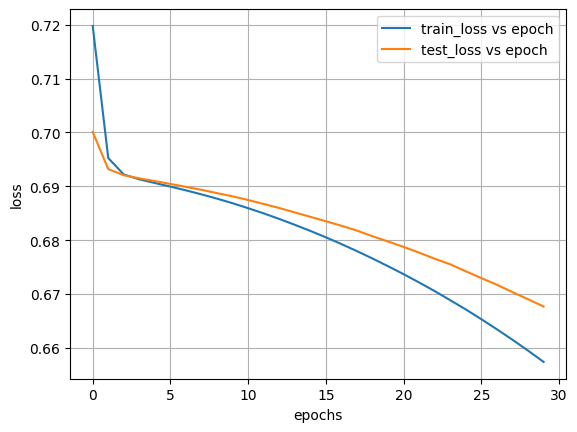

In [12]:
plt.plot(train_loss,label='train_loss vs epoch')
plt.plot(test_loss,label='test_loss vs epoch')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

## THE TASK WAS DONE WITH A PAIR:
- ## MARTA DASZKIEWICZ, BARTOSZ PAŚ